In [1]:

import cv2 as cv
import math
import numpy as np
from matplotlib import pyplot as plt
import random as rng
import glob
from IPython.display import Image, display

sift = cv.SIFT_create()
bf1 = cv.BFMatcher()
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
orb = cv.ORB_create()
print(orb)

<ORB 00000165A2D79790>


In [2]:
imgData = {
  "kp": [],
  "d": [],
  "images": []
}

matchData = {
  "matches": [],
  "score": [],
  "qu": [],
    'tr':[]
}


pairData = {
  "idx": 0,
  "score": 1000,
  "matchdata":matchData,
    "matrix1":[],
    "matrix2":[]
}

In [3]:
def getKeyp(folder):
    d=[]
    kp=[]
    images=[]
    print('finding data...')
    for imageName in glob.glob(folder+'/*.jpg'):
        i1 = cv.imread(imageName)
#         i1 = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
        kp1, d1 = orb.detectAndCompute(i1,None)#key points and detectors
        kp.append(kp1)
        d.append(d1)
        images.append(i1)
    print('data found')
    imgData['kp']=kp
    imgData['d']=d
    imgData['images']=images
#     print(imgData)
    return imgData

In [4]:
def getData(d1,d2,k1,k2):
    s=0
    qu=[]
    tr=[]
    kp1=[]
    kp2=[]
    good_points =[]
    matches = bf.match(d1,d2)
# Sort them in the order of their distance.
    orderedmatches = sorted(matches, key = lambda x:x.distance)
    numTosum=int(len(matches)/10)
    if numTosum<1:
        numTosum=1
    if numTosum%2:
        numTosum=numTosum-1
    for m in orderedmatches[:numTosum]:
        qu.append(m.queryIdx)
        tr.append(m.trainIdx)
        s=s+m.distance
    for m in orderedmatches:
        thresh=20
        if 2*orderedmatches[0].distance>thresh:
            thresh=2*orderedmatches[0].distance
        if m.distance <= thresh and len(good_points)<60:
            kp1.append(k1[m.queryIdx].pt)
            kp2.append(k2[m.trainIdx].pt)
            good_points.append(m)
    
    matchData = {
  "matches": matches,
  "score": (s/numTosum),
  "qu": qu,
    'tr':tr,
        'gp':good_points,
        'kp1':kp1,
        "kp2":kp2
}
    return matchData

In [5]:
def getPairs(folder):
    imgdata=getKeyp(folder)
    data=[]
    pairs=[]
    pair=[]
    matchData=[]
    thresh=20
    for i in range(0,len(imgdata["d"])-1):
        pairData = {
            "idx": 0,
            "score": 1000,
            "matchdata":matchData,
            "matrix1":[],
            "matrix2":[]
            }
#         print("")
#         print(i)
        for j in range(i+1,len(imgdata["d"])):
            matchData= getData(imgdata["d"][i],imgdata["d"][j],imgdata["kp"][i],imgdata["kp"][j])
#             print(matchData["score"])
#             office:20
#             james:25    
            if folder == 'office':
                thresh=20
            else:
                thresh=30
            if(matchData["score"]<thresh):
                pairData = {
            "idx": j,
            "score": matchData["score"],
            "matchdata":matchData,
            "matrix1":[],
            "matrix2":[]
            }
                pair.append(pairData)
#         print(len(pair))
#         pair = sorted(pair, key = lambda x:x['score'])
        pairs.append(pair)
        pair=[]
    Data = {
            "pairs":pairs,
            "imgdata" : imgdata
            }
#     print(Data)
    return Data

In [6]:
def  getMat(data):
    mat = []
    tempmat = []
    idx = 0
    
    for p in data["pairs"]:
        if len(p) ==0:
            print("***ERROR***")
#         print(len(p))
        idx = 0
        for i in range(len(p)):
#             p1 = np.float32(p[i]["matchdata"]["qu"]).reshape(-1,1,2)
#             p2 = np.float32(p[p[i]["idx"]]["matchdata"]["tr"]).reshape(-1,1,2)
            print(len(p[i]['matchdata']['gp']))
            p1=np.array([p[i]['matchdata']['kp1']])
            p2=np.array([p[i]['matchdata']['kp2']])
            
            img1=data["imgdata"]["images"][idx]
            img2=data["imgdata"]["images"][p[idx]["idx"]]
            img3=img1.copy()
#         img3 = cv.drawMatches(img1,data["imgdata"]["kp"][i],img2,data["imgdata"]["kp"][data["pairs"][i]["idx"]],data["pairs"][i]["matchdata"]["matches"], outImg=img3,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#         plt.imshow(img3),plt.show()
            M, mask = cv.findHomography(p2, p1, cv.RANSAC,5.0)
            M1, mask = cv.findHomography(p1, p2, cv.RANSAC,5.0)
            tempmat.append(M)
            mat.append(tempmat)
            p[i]["matrix1"] = M
            p[i]["matrix2"] = M1
            tempmat = []
        idx=idx+1
    
    return data

In [7]:
pairData = getPairs("james")
print("d")

finding data...
data found
d


In [8]:
matData=getMat(pairData)

print("d")

47
20
50
36
18
16
23
28
12
34
31
17
11
***ERROR***
55
13
14
35
28
41
22
6
47
6
7
5
22
43
37
35
33
14
36
30
24
20
13
13
23
24
34
9
50
33
d


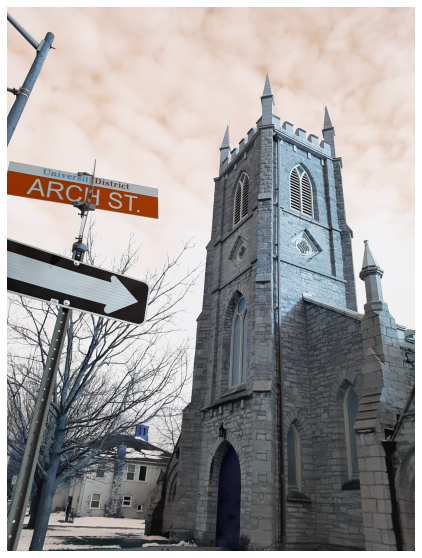

In [9]:
i=0
j=1
data=matData
q=data["imgdata"]["images"][i]
t= data["imgdata"]["images"][data["pairs"][i][0]["idx"]]
plt.figure(figsize=(20,10))
plt.imshow(q)

plt.axis('off')
plt.show()

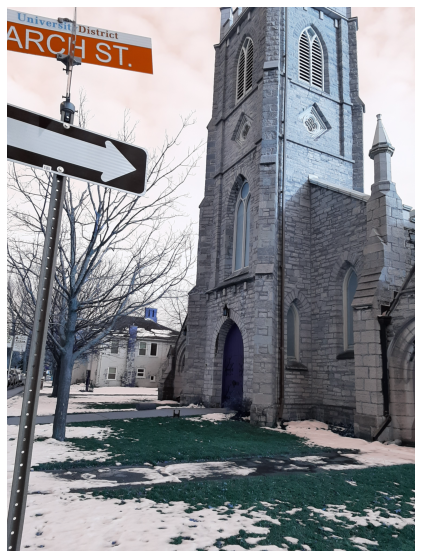

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(t)

plt.axis('off')
plt.show()

In [11]:
def stitch(i,j,done,carry):
    done.append(i)
    result=[]
    skip = 0
    if data["pairs"][i][j]["idx"]==len(data["pairs"]) or i==len(data["pairs"]) or len(data["pairs"][i])==0:
        done.append(data["pairs"][i][j]["idx"])
        print("*")
        return [],0
    queryImg=data["imgdata"]["images"][i]
    trainImg=data["imgdata"]["images"][data["pairs"][i][j]["idx"]]
    print(data["pairs"][i][j]["idx"])
#     print(len(data["pairs"][i]))
    for ix in done:
        if data["pairs"][i][j]["idx"] == ix:
            skip=1
    if skip == 0:        
        carry=stitch(data["pairs"][i][j]["idx"],0,done,[])[0]
    if len(carry)>0:
        trainImg=carry
    width = trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]

    result = cv.warpPerspective(trainImg,data["pairs"][i][j]["matrix1"] , (width, height))
    result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

    plt.figure(figsize=(20,10))
    plt.imshow(result)

# plt.axis('off')
    plt.show()
    return result,data["pairs"][i][j]["idx"]

6
7
8
9
10
11
12
13
14
*


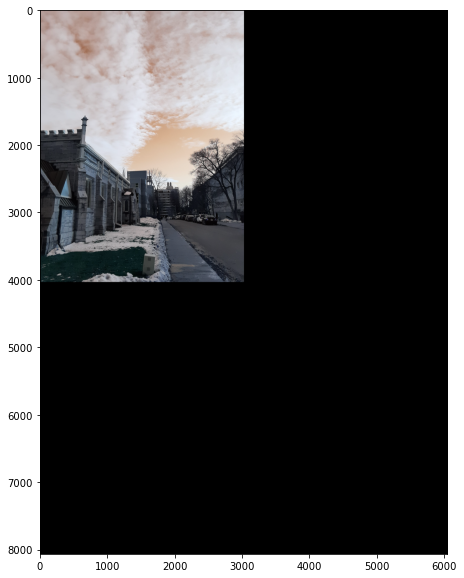

In [ ]:
a=5
x=stitch(a,0,[],[])

In [ ]:
# x1=stitch(a,0,[],stitch(x[1],0,[],[])[0])

In [ ]:
# x11=stitch(a,0,[],stitch(x[1],0,[],stitch(x1[1],0,[],[])[0])[0])

In [ ]:
# x=stitch(a,0,[],stitch(x[1],0,[],stitch(x1[1],0,[],stitch(x11[1],0,[],[])[0])[0])[0])

In [ ]:
i=5
j=0
q=data["imgdata"]["images"][i]
t= data["imgdata"]["images"][data["pairs"][i][j]["idx"]]
result1=[]
queryImg=q
trainImg=t
print(data["pairs"][i][j]["idx"])
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result1 = cv.warpPerspective(trainImg,data["pairs"][i][j]["matrix1"] , (width, height))
result1[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result1)

# plt.axis('off')
plt.show()

In [ ]:
i=1
j=0
print(data["pairs"][i][j]["idx"])
q=data["imgdata"]["images"][i]
t= data["imgdata"]["images"][data["pairs"][i][j]["idx"]]
result=[]
queryImg=q
trainImg=result1
print(data["pairs"][i][j]["idx"])
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv.warpPerspective(trainImg,data["pairs"][i][j]["matrix1"] , (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

# plt.axis('off')
plt.show()

In [ ]:
i=0
j=0
q=data["imgdata"]["images"][i]
t= data["imgdata"]["images"][data["pairs"][i][j]["idx"]]
result1=[]
queryImg=q
trainImg=result
print(data["pairs"][i][j]["idx"])
width = trainImg.shape[1] 
height = trainImg.shape[0] 

result1 = cv.warpPerspective(trainImg,data["pairs"][i][j]["matrix1"] , (width, height))
result1[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result1)

# plt.axis('off')
plt.show()

In [ ]:
# i=0
# j=1
# trainImg=data["imgdata"]["images"][i]
# queryImg= data["imgdata"]["images"][data["pairs"][i][1]["idx"]]
# x=result.copy()
# width = trainImg.shape[1] + queryImg.shape[1]
# height = trainImg.shape[0] + queryImg.shape[0]

# result = cv.warpPerspective(trainImg,data["pairs"][i][1]["matrix1"] , (width, height))
# # result[0:x.shape[0], 0:x.shape[1]] = x

# plt.figure(figsize=(20,10))
# plt.imshow(result)

# plt.axis('off')
# plt.show()

In [ ]:
# plt.imshow(refRet1)